# Topic Modeling with `k`-Means

This notebook performs topic modeling on a set of VMware last-chance searches. We'll cluster using `k`-means on TF-IDF vectors.

## Input Data

In [28]:
import sys
sys.path.append('..')

from scripts import corpora

In [29]:
last_week = corpora.load('../corpora/vmware-last-week')
last_month = corpora.load('../corpora/vmware-last-month')
last_six_months = corpora.load('../corpora/vmware-last-six-months')
vsphere_65 = corpora.load('../corpora/vsphere-6.5-last-month')

## Algorithm

This code leverages Scikit-learn's KMeans and TfidfVectorizer classes.

In [30]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance

In [31]:
MIN_DF = 1
MAX_DF = 0.1
N_JOBS = -1   # use all available CPUs

class TopicModeler:

    def __init__(self, corpus, n_topics, key=None):
        if not key:
            key = lambda x: x
        self.corpus = corpus
        self.n_topics = n_topics
        self.key = key
        self.model, self.vectorizer = None, None

    def run(self):
        vectors = self.vectorize()
        self.model = KMeans(n_clusters=self.n_topics, n_jobs=N_JOBS).fit(vectors)

    def vectorize(self):
        self.vectorizer = TfidfVectorizer(stop_words='english', min_df=MIN_DF, max_df=MAX_DF)
        vectors = self.vectorizer.fit_transform([self.key(document) for document in self.corpus])
        return vectors
    
    def find_centroid(self, topic_id):
        return {term: self.model.cluster_centers_[topic_id][index]
                for term, index in self.vectorizer.vocabulary_.items()}
    
    def get_cluster(self, topic_id):
        return [document for index, document in enumerate(self.corpus)
                if self.model.labels_[index] == topic_id]
    
    def get_key_terms(self, topic_id, n=5):
        centroid = self.find_centroid(topic_id)
        return sorted(centroid, key=centroid.get, reverse=True)[:n]
    
    def compute_distance(self, document, topic_id):
        vector = self.vectorizer.transform([self.key(document)])
        centroid = self.model.cluster_centers_[topic_id]
        return distance.euclidean(vector.toarray(), centroid)

## Graphing Helpers

The following function displays a histogram of cluster size.

In [32]:
import matplotlib.pyplot as plt

def show_count_histogram(modeler, title, bins=100):
    labels = modeler.model.labels_.tolist()
    plt.hist([labels.count(n) for n in range(modeler.n_topics)], bins=bins, color='grey')
    plt.title(title)
    plt.xlabel('Number of Searches')
    plt.show()

## Export Functions

In [33]:
import csv
import os

from topic_modeling.naming import find_top_n_grams, find_best_sentence

Firstly, let's write a function that exports a set of information about each topic. This function creates a CSV with the columms `Topic ID`, `Key Terms`, `Top Unigrams`, `Top Bigrams`, `Top Trigrams`, `Best Sentence`, and `Document Count`.

In [34]:
def export_topics(modeler, directory):
    with open(os.path.join(directory, 'topics.csv'), 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Topic ID', 'Key Terms', 'Top Unigrams', 'Top Bigrams', 'Top Trigrams',
                         'Best Sentence', 'Document Count'])
        for n in range(modeler.n_topics):
            documents = [search.body for search in modeler.get_cluster(n)]
            key_terms = modeler.get_key_terms(n)
            writer.writerow([
                n,
                ', '.join(key_terms),
                ', '.join(find_top_n_grams(documents, 1)) if len(documents) < 20000 else '',
                ', '.join(find_top_n_grams(documents, 2)) if len(documents) < 20000 else '',
                ', '.join(find_top_n_grams(documents, 3)) if len(documents) < 20000 else '',
                find_best_sentence(documents, key_terms) if len(documents) < 20000 else '',
                len(documents)
            ])

Secondly, we'll create a function that exports topic assignments. This function writes a CSV with the columns `Topic ID`, `Session ID`, `Distance`, and `Body`.

In [35]:
def export_documents(modeler, directory):
    with open(os.path.join(directory, 'documents.csv'), 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Topic ID', 'Session ID', 'Distance', 'Body'])
        for n in range(modeler.n_topics):
            for search in modeler.get_cluster(n):
                distance = modeler.compute_distance(search, n)
                writer.writerow([n, search.session_id, distance, search.body])

## Last Week, 10 Topics

In [9]:
modeler = TopicModeler(last_week, 10, key=lambda search: search.body)
modeler.run()

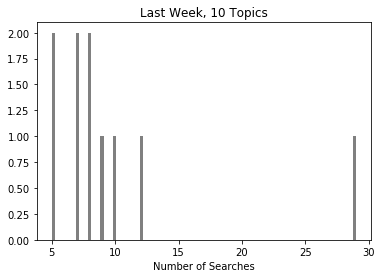

In [10]:
show_count_histogram(modeler, "Last Week, 10 Topics")

In [11]:
output_directory = '../output/k-means/last-week-10-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Week, 25 Topics

In [12]:
modeler = TopicModeler(last_week, 25, key=lambda search: search.body)
modeler.run()

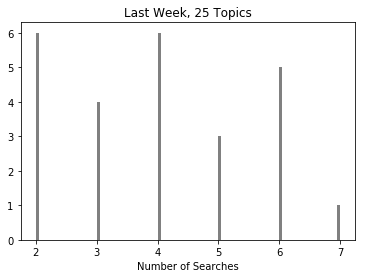

In [13]:
show_count_histogram(modeler, "Last Week, 25 Topics")

In [14]:
output_directory = '../output/k-means/last-week-25-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Week, 50 Topics

In [15]:
modeler = TopicModeler(last_week, 50, key=lambda search: search.body)
modeler.run()

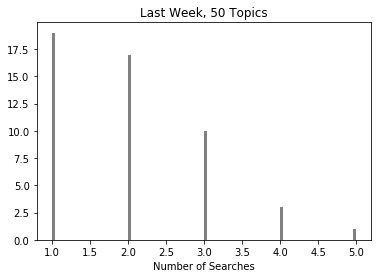

In [16]:
show_count_histogram(modeler, "Last Week, 50 Topics")

In [17]:
output_directory = '../output/k-means/last-week-50-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Week, 75 Topics

In [18]:
modeler = TopicModeler(last_week, 75, key=lambda search: search.body)
modeler.run()

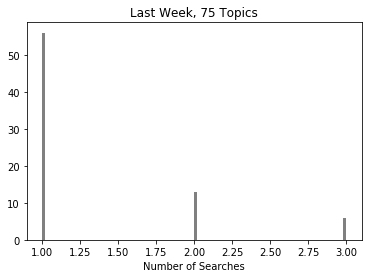

In [19]:
show_count_histogram(modeler, "Last Week, 75 Topics")

In [20]:
output_directory = '../output/k-means/last-week-75-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Week, 100 Topics

In [21]:
modeler = TopicModeler(last_week, 100, key=lambda search: search.body)
modeler.run()

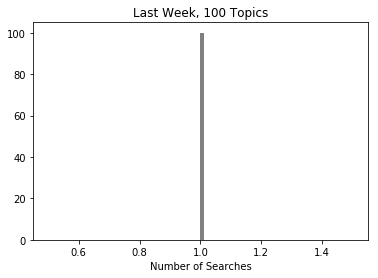

In [22]:
show_count_histogram(modeler, "Last Week, 100 Topics")

In [23]:
output_directory = '../output/k-means/last-week-100-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Month, 10 Topics

In [24]:
modeler = TopicModeler(last_month, 10, key=lambda search: search.body)
modeler.run()

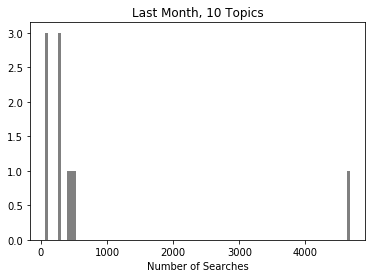

In [25]:
show_count_histogram(modeler, "Last Month, 10 Topics")

In [26]:
output_directory = '../output/k-means/last-month-10-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Month, 25 Topics

In [27]:
modeler = TopicModeler(last_month, 25, key=lambda search: search.body)
modeler.run()

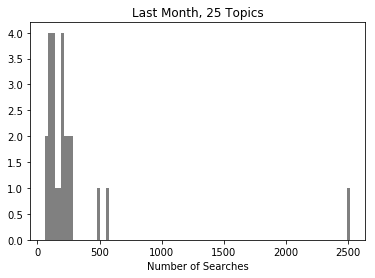

In [28]:
show_count_histogram(modeler, "Last Month, 25 Topics")

In [29]:
output_directory = '../output/k-means/last-month-25-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Month, 50 Topics

In [30]:
modeler = TopicModeler(last_month, 50, key=lambda search: search.body)
modeler.run()

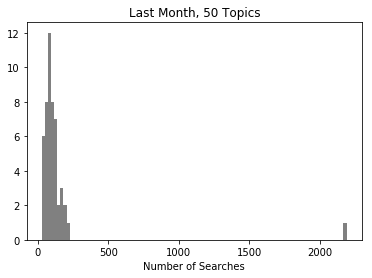

In [31]:
show_count_histogram(modeler, "Last Month, 50 Topics")

In [32]:
output_directory = '../output/k-means/last-month-50-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Month, 75 Topics

In [33]:
modeler = TopicModeler(last_month, 75, key=lambda search: search.body)
modeler.run()

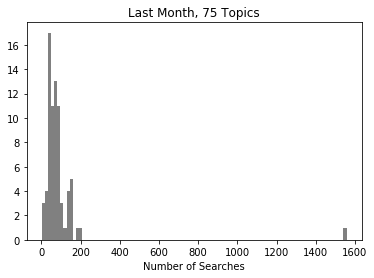

In [34]:
show_count_histogram(modeler, "Last Month, 75 Topics")

In [35]:
output_directory = '../output/k-means/last-month-75-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## Last Month, 100 Topics

In [36]:
modeler = TopicModeler(last_month, 100, key=lambda search: search.body)
modeler.run()

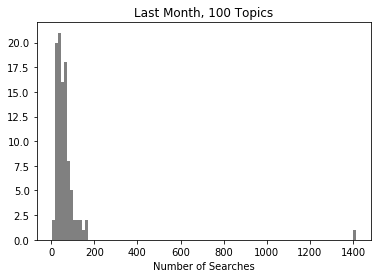

In [37]:
show_count_histogram(modeler, "Last Month, 100 Topics")

In [38]:
output_directory = '../output/k-means/last-month-100-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5, 10 Topics

In [9]:
modeler = TopicModeler(vsphere_65, 10, key=lambda search: search.body)
modeler.run()

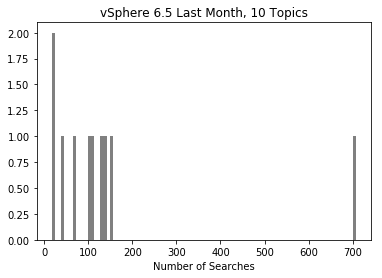

In [10]:
show_count_histogram(modeler, "vSphere 6.5 Last Month, 10 Topics")

In [ ]:
output_directory = '../output/k-means/vsphere-65-last-month-10-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5, 25 Topics

In [12]:
modeler = TopicModeler(vsphere_65, 25, key=lambda search: search.body)
modeler.run()

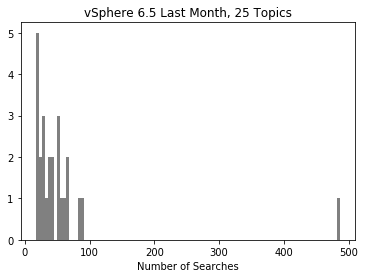

In [13]:
show_count_histogram(modeler, "vSphere 6.5 Last Month, 25 Topics")

In [ ]:
output_directory = '../output/k-means/vsphere-65-last-month-25-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5, 50 Topics

In [15]:
modeler = TopicModeler(vsphere_65, 50, key=lambda search: search.body)
modeler.run()

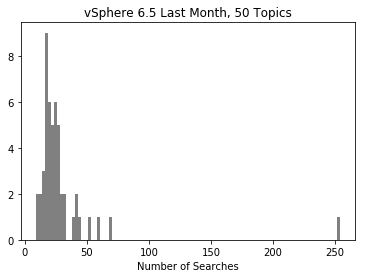

In [16]:
show_count_histogram(modeler, "vSphere 6.5 Last Month, 50 Topics")

In [ ]:
output_directory = '../output/k-means/vsphere-65-last-month-50-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5, 75 Topics

In [22]:
modeler = TopicModeler(vsphere_65, 75, key=lambda search: search.body)
modeler.run()

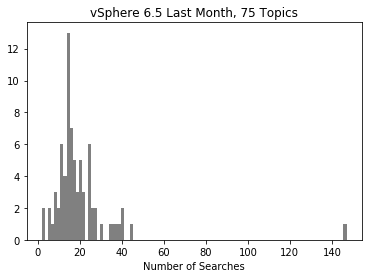

In [23]:
show_count_histogram(modeler, "vSphere 6.5 Last Month, 75 Topics")

In [ ]:
output_directory = '../output/k-means/vsphere-65-last-month-75-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)

## vSphere 6.5, 100 Topics

In [25]:
modeler = TopicModeler(vsphere_65, 100, key=lambda search: search.body)
modeler.run()

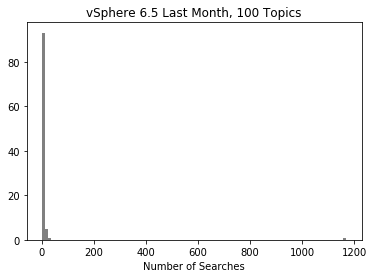

In [26]:
show_count_histogram(modeler, "vSphere 6.5 Last Month, 100 Topics")

In [ ]:
output_directory = '../output/k-means/vsphere-65-last-month-100-topics/'
os.makedirs(output_directory)
export_topics(modeler, output_directory)
export_documents(modeler, output_directory)